In [1]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


In [67]:
!pip install gdal GDAL

In [69]:
!apt-get install qgis python3-qgis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon fonts-dejavu-core fonts-lyx gcr gdal-bin geoclue-2.0
  glib-networking glib-networking-common glib-networking-services
  gnome-keyring gnome-keyring-pkcs11 grass-core grass-doc
  gsettings-desktop-schemas iio-sensor-proxy javascript-common libassimp5
  libavahi-core7 libavahi-glib1 libdaemon0 libdraco4 libevdev2 libexiv2-27
  libfcgi-bin libfcgi0ldbl libfftw3-double3 libgck-1-0 libgcr-base-3-1
  libgcr-ui-3-1 libglu1-mesa libgsl27 libgslcblas0 libgudev-1.0-0 libhyphen0
  libimagequant0 libinput-bin libinput10 libjs-leaflet libjson-glib-1.0-0
  libjson-glib-1.0-common liblbfgsb0 libmbim-glib4 libmbim-proxy libmd4c0
  libmm-glib0 libmng2 libmtdev1 libnl-genl-3-200 libnotify4 libnss-mdns
  libpam-gnome-keyring libpdal-plugin-e57 libpdal-plugin-faux
  libpdal-plugin-hdf libpdal-plugin-icebridge libpdal-plugin-pgpointcloud
  lib

In [107]:
!gdal_translate -of JPEG -co QUALITY=100 /content/tile_000000.tif out.jpg


Input file size is 512, 512
0Warning 1: 4-band JPEGs will be interpreted on reading as in CMYK colorspace
...10...20...30...40...50...60...70...80...90...100 - done.


In [2]:
!git clone https://github.com/PUTvision/qgis-plugin-deepness.git

Cloning into 'qgis-plugin-deepness'...
remote: Enumerating objects: 4583, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 4583 (delta 125), reused 115 (delta 115), pack-reused 4248 (from 3)
Receiving objects: 100% (4583/4583), 135.43 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (2909/2909), done.
Updating files: 100% (211/211), done.


In [37]:
!mv /content/qgis-plugin-deepness/src/deepness /content/


In [38]:
from huggingface_hub import login, hf_hub_download
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import torch
from PIL import Image
from deepness.processing.models.segmentor import Segmentor
from PIL import Image
import numpy as np

login("token")



In [4]:
hf_hub_download(repo_id="tferhan/mask2former_semantic_ma", filename="buildings_type_MA.onnx", repo_type="model", local_dir=".")
hf_hub_download(repo_id="tferhan/mask2former_semantic_ma", filename="deeplabv3_landcover_4c.onnx", repo_type="model", local_dir=".")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


buildings_type_MA.onnx:   0%|          | 0.00/464M [00:00<?, ?B/s]

deeplabv3_landcover_4c.onnx:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

'deeplabv3_landcover_4c.onnx'

In [5]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# Only normalization for inference
test_transform = A.Compose([
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ToTensorV2()
])

def preprocess_image(path):
    # Read image with cv2 (BGR → RGB)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply transformation
    transformed = test_transform(image=img)
    tensor = transformed["image"].unsqueeze(0)  # [1, 3, H, W]
    return tensor



In [108]:
pixel_values = preprocess_image("/content/out.jpg")
print(pixel_values.shape)  # [1, 3, H, W]
print(pixel_values.dtype)  # torch.float32

torch.Size([1, 3, 512, 512])
torch.float32


In [7]:
import onnxruntime as ort
ort_session = ort.InferenceSession("/content/buildings_type_MA.onnx", providers=["CPUExecutionProvider"])



In [109]:
pixel_values_np = pixel_values.cpu().numpy().astype(np.float32)

In [110]:
logits_np = ort_session.run(["logits", "outputs_mask.35"], {"pixel_values": pixel_values_np})

In [111]:
logits = torch.from_numpy(logits_np[0])
masks = torch.from_numpy(logits_np[1])

In [13]:
from transformers.models.mask2former.modeling_mask2former import Mask2FormerForUniversalSegmentationOutput


In [75]:
mask2formerlogits = Mask2FormerForUniversalSegmentationOutput(class_queries_logits=logits, masks_queries_logits=masks)

In [76]:
preprocessor = Mask2FormerImageProcessor(num_labels = 5, ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [112]:
target_sizes = [(512, 512)]
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(mask2formerlogits, target_sizes=target_sizes)

In [113]:
image = Image.open("/content/out.jpg").convert("RGB")
image = np.array(image)

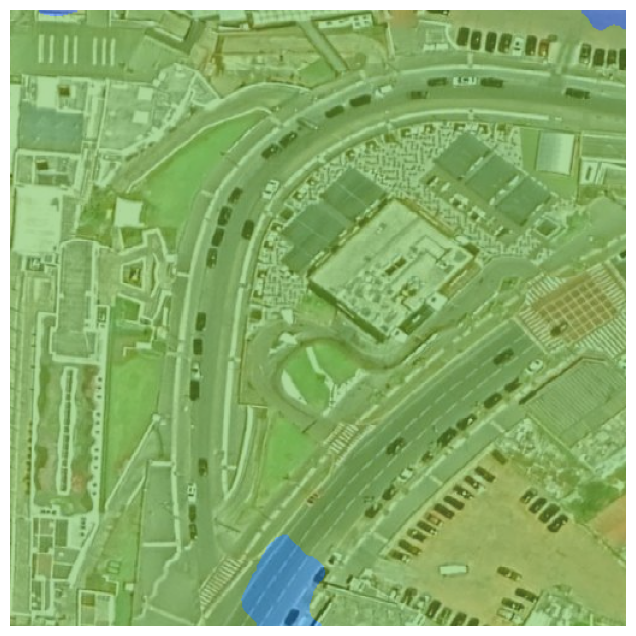

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Get the segmentation map
segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

# Generate a random palette (one color per class)
num_classes = segmentation_map.max() + 1
np.random.seed(42)  # For reproducibility
palette = np.random.randint(0, 256, size=(num_classes, 3), dtype=np.uint8)

# Map labels to colors
color_segmentation_map = palette[segmentation_map]

# If your image is a tensor (C,H,W), convert to numpy (H,W,C)
if hasattr(image, "permute"):
    image = image.permute(1, 2, 0).cpu().numpy()

# Blend
blended_img = (image * 0.5 + color_segmentation_map * 0.5).astype(np.uint8)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(blended_img)
plt.axis("off")
plt.show()


In [115]:
def load_image_as_array_batched(path):
    """
    Load image and return as [1, H, W, C], dtype=uint8 for Deepness models.
    """
    img = Image.open(path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    return arr[np.newaxis, ...]  # shape becomes (1, H, W, C)

seg = Segmentor("/content/deeplabv3_landcover_4c.onnx")
pixel = load_image_as_array_batched("/content/out.jpg")


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [81]:
pixel.shape

(1, 512, 512, 3)

In [116]:
res = seg.process(pixel)
onnx_classes = np.argmax(res[0], axis=1)[0]
BUILDING_ID = 1
ROAD_ID = 4
TREE_ID = 2

In [117]:
res[0].shape

(1, 5, 512, 512)

In [118]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_mask_overlay(image, mask, alpha=0.5, seed=42):
    """
    Visualize an image, its mask, and the overlay.

    Parameters
    ----------
    image : np.ndarray
        Original image (H, W, 3), dtype uint8, values 0-255.
    mask : np.ndarray
        Segmentation mask (H, W), dtype int, values = class indices.
    alpha : float
        Transparency for overlay (0 = only image, 1 = only mask).
    seed : int
        Random seed for consistent colors.
    """
    # Ensure mask is integer
    mask = mask.astype(np.int32)

    # Create color palette
    num_classes = int(mask.max()) + 1
    np.random.seed(seed)
    palette = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)

    # Map classes to colors
    color_mask = palette[mask]

    # Overlay
    overlay = (image * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    # Plot
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask")
    plt.imshow(color_mask)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


In [119]:
BUILDING_OFFSET = 10

merged_mask = onnx_classes.copy()

# Mask for building pixels from Deeplab
building_pixels = (onnx_classes == BUILDING_ID)

# Building type predictions from your model
building_types = segmentation_map[building_pixels]

# Encode building types into new unique IDs
# Keep Deeplab ID (1) if your model says background (0)
encoded_buildings = np.where(
    building_types != 0,
    BUILDING_ID + building_types * BUILDING_OFFSET,
    BUILDING_ID
)

# Place the encoded values back into the merged mask
merged_mask[building_pixels] = encoded_buildings

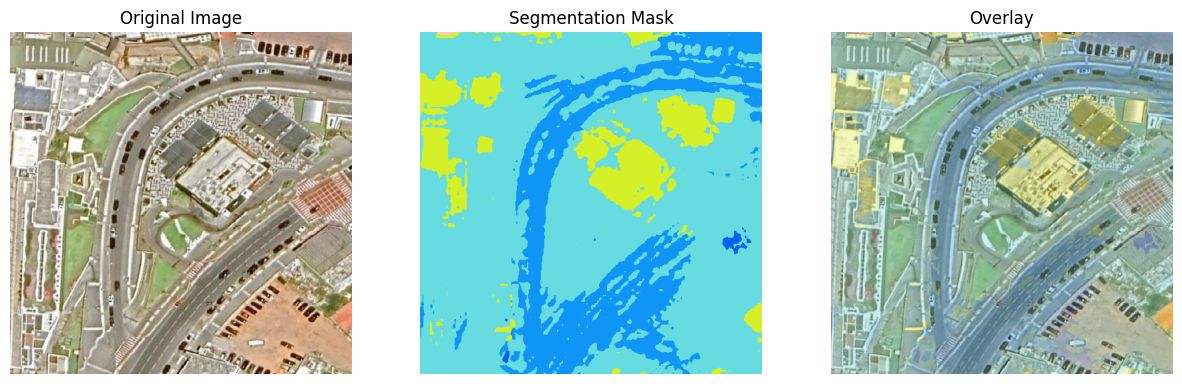

In [120]:
visualize_mask_overlay(image, merged_mask, alpha=0.3)

In [64]:
!pip install rasterio shapely geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.7 MB/s eta 0:00:00


In [122]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# --- Read GeoTIFF metadata ---
geotiff_path = "/content/tile_000000.tif"
with rasterio.open(geotiff_path) as src:
    transform = src.transform
    crs = src.crs

# --- Convert merged mask to polygons ---
results = (
    {"properties": {"class_id": int(v)}, "geometry": s}
    for s, v in shapes(merged_mask.astype(np.int16), mask=None, transform=transform)
)

# --- Create list of geometries with final label ---
geoms = []
for r in results:
    geom = shape(r["geometry"])
    class_id = r["properties"]["class_id"]
    geoms.append({"geometry": geom, "class_id": class_id})

# --- Make GeoDataFrame ---
gdf = gpd.GeoDataFrame(geoms, geometry="geometry", crs=crs)

# --- Optional: Map IDs to names (final labels) ---
class_map = {
    0: "background",
    1: "building",       # if still present anywhere
    2: "tree",
    3: "other",
    4: "road",
    11: "not_residential",
    21: "house",
    31: "residential",
    41: "apartments"

}
gdf["class_name"] = gdf["class_id"].map(class_map).fillna("unknown")

# --- Save to GeoJSON ---
output_geojson = "/content/resu55ccs.geojson"
gdf.to_file(output_geojson, driver="GeoJSON")

print(f"✅ GeoJSON saved at: {output_geojson}")


✅ GeoJSON saved at: /content/resu55ccs.geojson
